In [3]:
import bayescart
import numpy as np
import scipy
from scipy.special import gammaln
import matplotlib.pyplot as plt
import time
import pandas as pd
from typing import Sequence, Self, Any
import numpy.typing as npt
import math
from tqdm import tqdm
import humanize
from bayescart.node import Node
from bayescart.node_data import NodeData, NodeDataRegression, NodeDataClassification, NodeDataRegressionFast, NodeDataClassificationFast
from bayescart.tree import Tree, TreeFast
from bayescart.exceptions import InvalidTreeError, AbstractMethodError
from bayescart.utils import my_choice, invgamma_rvs, invgamma_logpdf, norm_logpdf, dirichlet_logpdf
from bayescart.mytyping import NDArrayFloat, NDArrayInt, T
from functools import wraps

In [5]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [31]:
#데이터 생성하기
# 샘플 크기
n = 5000

# 설명 변수 생성
x1 = np.random.choice(["-3", "-2", "-1", "1", "2", "3"], size=n)
x2 = np.random.normal(0, 1, size=n)
x3 = np.random.uniform(-1, 1, size=n)
x4 = np.random.uniform(-1, 1, size=n)
x5 = np.random.normal(0, 1, size=n)
x6 = np.random.normal(0, 1, size=n)
x7 = np.random.choice(["-3", "-2", "-1", "1", "2", "3"], size=n)
x8 = np.random.choice(["-3", "-2", "-1", "1", "2", "3"], size=n)

# 노출 변수
v = np.random.uniform(0, 1, size=n)

# Poisson 강도 함수 λ(x1, x2)
lambda_values = np.where(x1.astype(int) * x2 <= 0, 1, 7)

# 응답 변수 N 생성
N = np.random.poisson(lambda_values * v)

# 데이터프레임 생성
df = pd.DataFrame({
    "x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5, "x6": x6, "x7": x7, "x8": x8,
    "v": v, "N": N
})
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,v,N
0,1,0.906106,-0.031095,-0.767910,-0.158496,0.435555,3,-1,0.267012,1
1,-3,-1.189894,-0.899737,-0.315592,0.277660,1.793246,2,3,0.530187,5
2,-1,0.661650,0.492973,-0.327270,-0.632864,0.262077,-1,-1,0.920310,1
3,-2,0.179684,0.454231,0.057279,0.227645,-1.019198,-2,-2,0.074978,1
4,1,0.488537,-0.501315,0.383269,-0.843593,-0.172418,3,3,0.714842,6


In [33]:
#데이터 분할
X = df.drop(columns=["N","v"])
y= df["N"]

In [35]:
#Tree prior
from sklearn.tree import DecisionTreeRegressor
def tree_depth(node_ids):
    return np.floor(np.log2(node_ids+1)).astype(int)

def tree_prior(model, alpha_split, beta_split, num_variables):
    nodes = model.tree_.children_left
    node_ids = np.arange(len(nodes))

    depth = tree_depth(node_ids).astype(float)

    prior_split = alpha_split * (1.0 + depth) ** (-beta_split)
    prior_rule = np.full_like(depth,1.0/num_variables,dtype=float)

    tree_prior_value = np.log(np.prod(prior_split)*np.prod(prior_rule))
    return tree_prior_value

In [37]:
#integrated likelihood 계산
from scipy.special import gamma
#terminal node t에 대한 integrated likelihood
def poisson_integrated_likelihood(N_t, v_t, alpha_lambda, beta_lambda):
    N_t_sum = np.sum(N_t)  # Σ N_ti
    v_t_sum = np.sum(v_t)  # Σ v_ti

    # Integrated likelihood 계산
    likelihood = np.log(
        (beta_lambda ** alpha_lambda) * np.prod(v_t ** N_t) * gamma(N_t_sum + alpha_lambda) /
        (gamma(alpha_lambda) * np.prod([gamma(n + 1) for n in N_t]) * (v_t_sum + beta_lambda) ** (N_t_sum + alpha_lambda))
    )
    
    return likelihood

#트리 T에 대한 integrated likelihood
def tree_integrated_likelihood(tree_nodes, alpha_lambda, beta_lambda):
    total_likelihood = np.sum([
        poisson_integrated_likelihood(node["N_t"], node["v_t"], alpha_lambda, beta_lambda) for node in tree_nodes
    ])
    return total_likelihood

In [39]:
#posterior 계산
def calculate_posterior(model, tree_nodes, alpha_split, beta_split, num_variables, alpha_lambda, beta_lambda):
    # Tree prior 계산
    tree_prior_value = tree_prior(model, alpha_split, beta_split, num_variables)
    # Tree Integrated Likelihood 계산
    total_likelihood = tree_integrated_likelihood(tree_nodes,alpha_lambda,beta_lambda)
    #posterior probability 계산
    posterior_probability = total_likelihood * tree_prior_value

    return posterior_probability

In [41]:
#initial tree 생성
initial_tree_generate = DecisionTreeRegressor(
    max_depth=1,
    random_state=50
)
initial_tree = initial_tree_generate.fit(X,y)

In [ ]:
results = calculate_posterior(initial_tree,

<function matplotlib.pyplot.show(close=None, block=None)>

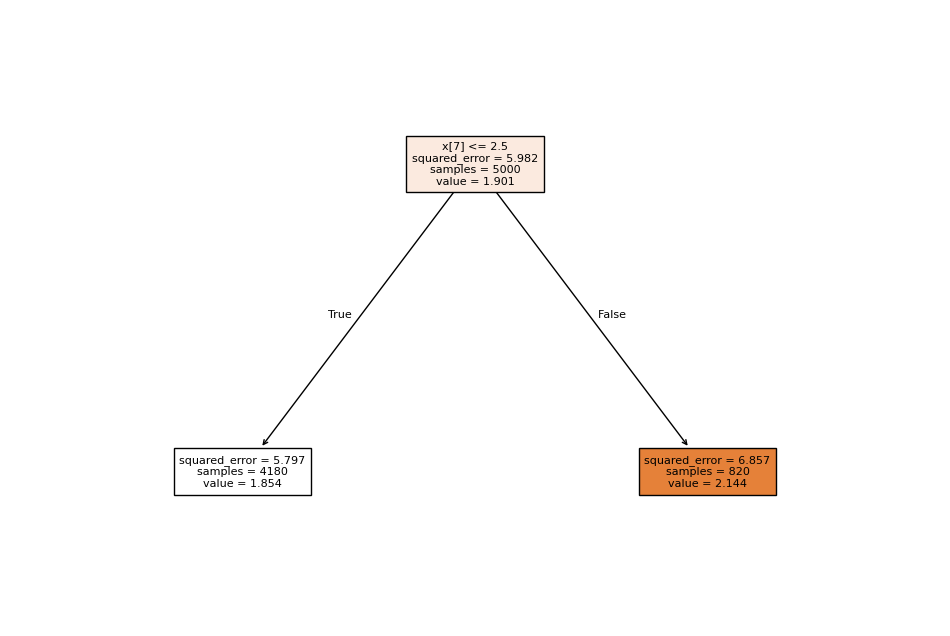

In [35]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(12,8))
plot_tree(initial_tree,
          filled=True,
          fontsize=8
)
plt.show

In [195]:
from bayescart.node import Node
from bayescart.node_data import NodeData, NodeDataRegression, NodeDataClassification, NodeDataRegressionFast, NodeDataClassificationFast
from bayescart.tree import Tree, TreeFast
from bayescart.exceptions import InvalidTreeError, AbstractMethodError
from bayescart.utils import my_choice, invgamma_rvs, invgamma_logpdf, norm_logpdf, dirichlet_logpdf
from bayescart.mytyping import NDArrayFloat, NDArrayInt, T

#Grow
def grow_copy(self, *args, light=False, **kwargs) -> Tree:

    # 트리 복사
    new_tree = self.tree.copy(light=light)

    # Debug 모드에서 검사
    if self.debug and len(self.mh_move_data) != 0:
        raise ValueError('mh_move_data should be Empty. BUG!!')

    # 리프 노드 중에서 랜덤으로 하나 선택
    node_to_split = new_tree.sample_leaf(self.node_min_size)

    # 새로운 분할 기준(splitting rule) 생성
    split_var, split_val = node_to_split.get_new_split()

    # 새로운 리프 노드 파라미터 샘플링
    l_leaf_params, r_leaf_params = self.sample_leaf_params()

    # 트리에 새로운 분할 적용
    new_tree.apply_split(node_to_split, split_var, split_val, l_leaf_params, r_leaf_params)

    # Debug 검사 (노드 개수 증가 확인)
    if self.debug:
        assert self.tree.get_n_leaves() + 1 == new_tree.get_n_leaves()

    return new_tree

In [197]:
#Prune
def prune_copy(self, *args, light=False, **kwargs) -> Tree:  
    # 트리 복사
    new_tree = self.tree.copy(light=light)

    # Debug 검사
    if self.debug and len(self.mh_move_data) != 0:
        raise ValueError('mh_move_data should be empty. BUG!!')

    # 트리가 이미 최소 크기라면 더 이상 축소 불가
    if new_tree.is_stump():
        raise InvalidTreeError('Tree has only one node. Cannot prune.')

    # 부모 노드 중에서 두 개의 리프 노드를 가진 후보 찾기
    cands = new_tree.get_parents_with_two_leaves()
    if len(cands) == 0:
        raise InvalidTreeError('No available nodes to prune')

    # 삭제할 노드 선택
    to_prune: Node = my_choice(self.rng, cands)
    children = new_tree.get_children(to_prune)

    # 리프 노드 2개 삭제
    removed = 0
    removed += new_tree.remove_node(children[0])
    removed += new_tree.remove_node(children[1])

    # Debug 검사 (노드 개수 감소 확인)
    if self.debug:
        assert removed == 2
        assert new_tree.get_n_leaves() + 1 == self.tree.get_n_leaves()

    # 부모 노드의 분할 정보 제거 (이제 리프 노드가 됨)
    to_prune.reset_split_info()

    return new_tree

In [199]:
#Change
def change_copy(self, *args, light=False, **kwargs) -> Tree:
    # 트리 복사
    new_tree = self.tree.copy(light=light)

    # Debug 검사
    if self.debug and len(self.mh_move_data) != 0:
        raise ValueError('mh_move_data should be empty. BUG!!')

    # 트리가 너무 작으면 변경 불가
    if new_tree.is_stump():
        raise InvalidTreeError('Tree has only one node. Cannot change.')

    # 내부 노드 중에서 하나 선택
    cands = new_tree.get_nonleaf_nodes()
    to_change: Node = my_choice(self.rng, cands)

    # 새로운 분할 기준 생성
    split_var, split_val = to_change.get_new_split()

    # 기존 분할을 새로운 값으로 변경
    new_tree.update_split(to_change, split_var, split_val)

    return new_tree

In [201]:
#Swap
def swap_copy(self, *args, light=False, **kwargs) -> Tree:
    # 트리 복사
    new_tree = self.tree.copy(light=light)

    # Debug 검사
    if self.debug and len(self.mh_move_data) != 0:
        raise ValueError('mh_move_data should be empty. BUG!!')

    # 내부 노드 중에서 하나 선택
    cands = new_tree.get_nonleaf_nodes(filter_root=True)
    c1 = my_choice(self.rng, cands)
    parent = new_tree.get_parent(c1)
    c2 = new_tree.get_sibling(c1)

    # 부모 노드의 분할 정보 가져오기
    par_s_var, par_s_val, _ = parent.get_split_info()

    # 부모와 자식 노드의 분할 기준 교환
    temp_s_var, temp_s_val, _ = c1.get_split_info()
    c1.update_split_info(par_s_var, par_s_val)
    parent.update_split_info(temp_s_var, temp_s_val)

    return new_tree

In [ ]:
#MCMC 알고리즘 정의
def P_BCART(X,y,iterations,alpha_split,beta_split,num_variables,alpha_lambda,beta_lambda,random_state=42):
    #initial tree 생성
    
    #initial tree의 posterior probability 계산
    
    #proposal tree 생성(이전 iteration에서 생성된 트리 기반 및 4가지 transition move 사용)
    
    #proposal tree의 posterior probability 계산

    #Acceptance ratio 계산

    #tree 선택

    #best tree 출력

In [203]:
import numpy as np
import pandas as pd
from bayescart import BCARTClassic

def P_BCART(X, y, iterations, alpha_split, beta_split, num_variables, alpha_lambda, beta_lambda, random_state=42):
    """
    MCMC 알고리즘을 사용하여 BCART 모델을 최적화하는 함수.
    """

    # ✅ 1. Initial Tree 생성 (초기에는 단일 노드 트리)
    model = BCARTClassic(X, y, iters=1010, burnin=10, thinning=1)

    # ✅ 2. Initial Tree Posterior Probability 계산
    current_tree = model.tree
    current_posterior = model.get_log_posterior_prob(current_tree)

    # ✅ Best Tree 초기화
    best_tree = current_tree
    best_posterior = current_posterior

    # ✅ 3. MCMC 반복 수행
    for i in range(iterations):
        print(f"Iteration {i+1}/{iterations}")

        # ✅ 유효한 Move 리스트 초기화
        available_moves = ["grow"]

        # 리프 노드가 2개 이상 있을 때만 Prune 가능
        if current_tree.get_n_leaves() > 1:
            available_moves.append("prune")

        # 내부 노드가 1개 이상 있어야 Change, Swap 가능
        if current_tree.get_n_leaves() > 2:
            available_moves.extend(["change", "swap"])

        # ✅ 유효한 Move 중 랜덤 선택
        move_type = np.random.choice(available_moves)

        # ✅ 4. Proposal Tree 생성 (선택한 Move에 따라 수행)
        proposed_tree = None  # 🔹 변수 초기화

        try:
            if move_type == "grow":
                proposed_tree = model.grow_copy()
            elif move_type == "prune":
                proposed_tree = model.prune_copy()
            elif move_type == "change":
                proposed_tree = model.change_copy()
            elif move_type == "swap":
                proposed_tree = model.swap_copy()
        except Exception as e:
            print(f"Move {move_type} failed with error: {e}, skipping iteration.")
            continue  # 🔹 오류 발생 시 다음 반복으로 넘어감

        # ✅ 5. Proposal Tree Posterior Probability 계산
        if proposed_tree is None:
            print(f"Skipping iteration {i+1} due to invalid tree proposal.")
            continue  # 🔹 트리가 없으면 다음 반복으로 넘어감

        proposed_posterior = model.get_log_posterior_prob(proposed_tree)

        # ✅ 6. Acceptance Ratio 계산 (Metropolis-Hastings Algorithm)
        acceptance_ratio = min(1, np.exp(proposed_posterior - current_posterior))

        # ✅ 7. Tree 선택 (새로운 트리를 유지할지 결정)
        if np.random.rand() < acceptance_ratio:
            current_tree = proposed_tree
            current_posterior = proposed_posterior
            print(f"Accepted new tree with posterior {current_posterior:.6f}")

            # ✅ 8. Best Tree 업데이트
            if current_posterior > best_posterior:
                best_tree = current_tree
                best_posterior = current_posterior

    print("MCMC Optimization Completed!")
    return best_tree


In [205]:
# ✅ MCMC 트리 탐색 실행
best_tree = P_BCART(X, y, iterations=50, alpha_split=0.95, beta_split=1, num_variables=10, alpha_lambda=2.0, beta_lambda=1.5)

# ✅ 최적 트리 출력
print("Best Tree Structure:")
print(best_tree)


Iteration 1/50
Accepted new tree with posterior -222746.344324
Iteration 2/50
Iteration 3/50
Move prune failed with error: Tree has only one node. Cannot prune., skipping iteration.
Iteration 4/50
Accepted new tree with posterior -103811.059315
Iteration 5/50
Iteration 6/50
Move prune failed with error: Tree has only one node. Cannot prune., skipping iteration.
Iteration 7/50
Iteration 8/50
Iteration 9/50


C:\Users\g0511\AppData\Local\Temp\ipykernel_28792\3756033797.py:63: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = min(1, np.exp(proposed_posterior - current_posterior))


Iteration 10/50
Iteration 11/50
Iteration 12/50
Move prune failed with error: Tree has only one node. Cannot prune., skipping iteration.
Iteration 13/50
Iteration 14/50
Iteration 15/50
Iteration 16/50
Move prune failed with error: Tree has only one node. Cannot prune., skipping iteration.
Iteration 17/50
Move prune failed with error: Tree has only one node. Cannot prune., skipping iteration.
Iteration 18/50
Iteration 19/50
Iteration 20/50
Move prune failed with error: Tree has only one node. Cannot prune., skipping iteration.
Iteration 21/50
Iteration 22/50
Iteration 23/50
Iteration 24/50
Iteration 25/50
Iteration 26/50
Iteration 27/50
Iteration 28/50
Iteration 29/50
Move prune failed with error: Tree has only one node. Cannot prune., skipping iteration.
Iteration 30/50
Move prune failed with error: Tree has only one node. Cannot prune., skipping iteration.
Iteration 31/50
Accepted new tree with posterior -79667.740947
Iteration 32/50
Iteration 33/50
Iteration 34/50
Iteration 35/50
Mov